In [1]:
from glob import glob
import pickle
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import sys
import pandas as pd

In [2]:
# Import from adjacent scripts.
import sys
import os
sys.path.append('..')
sys.path.append('../src')
sys.path.append('../audio')

import src.data_util as du
from src.defaults import DATA_PATH, MAX_INTEGER

In [3]:
# Get STRFs from one study type.

study_type = 1

df = du.load_and_clean_data()
df = du.min_max_norm(df)
df = du.isolate_study(df, study_type)
df = df.reset_index(drop=True)

with open('modulation_features.pickle', 'rb') as handle:
    tmp = pickle.load(handle)

print(tmp[0]['strf'].shape)

tmp = pd.DataFrame(tmp)
df = pd.merge(tmp, df, on='stimulus')
df['strf'] = df['strf'].transform(lambda x: x.flatten())

(128, 11, 22)


In [4]:
from sklearn.linear_model import LogisticRegression 

# Flatten STRF representation.
X = df['strf']
X = np.stack(X.to_numpy())

In [5]:
means_ = np.mean(X, axis=0)
stds_ = np.std(X, axis=0)

X = (X - means_)/stds_

In [6]:
# Convert response to binary above/below quantile.
quantile = 0.5

y = df.groupby('subjectNo')['response'].transform(
    lambda x: (x < np.quantile(x, q=quantile)).astype(int)
).to_numpy()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Score: 0.8920454545454546


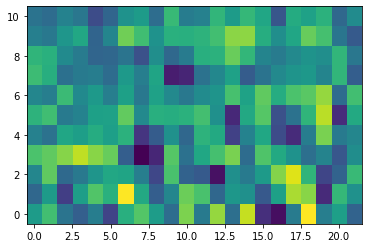

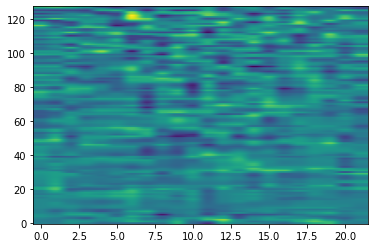

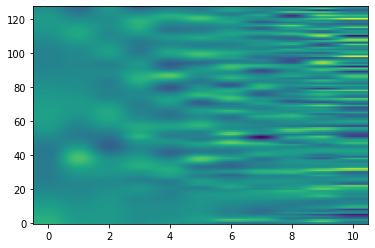

In [8]:
reg = LogisticRegression(penalty='l2', max_iter=400).fit(X, y)
print(f"Score: {reg.score(X, y)}")
learned_weights = reg.coef_.reshape(128, 11, 22)

strf_scale_rate = np.mean(learned_weights, axis=0)
strf_freq_rate = np.mean(learned_weights, axis=1)
strf_freq_scale = np.mean(learned_weights, axis=2)

plt.imshow(strf_scale_rate, origin='lower', aspect='auto')
plt.show()

plt.imshow(strf_freq_rate, origin='lower', aspect='auto')
plt.show()

plt.imshow(strf_freq_scale, origin='lower', aspect='auto')
plt.show()

In [175]:
def plotStrfavg(strf_scale_rate, strf_freq_rate, strf_freq_scale,aspect_='auto', interpolation_='none',figname='defaut',show='true'):
    rates = [4.0, 5.7, 8.0, 11.3, 16.0, 22.6, 32.0, 45.3, 64.0, 90.5, 128.0]
    rates = np.append(-1 * rates[::-1], rates)
    
    scales = [0.25, 0.35, 0.50, 0.71, 1.00, 1.41, 2.00, 2.83, 4.00, 5.66, 8.00]
    
    
    plt.suptitle(figname, fontsize=10)
    plt.subplot(1,3,1)
    plt.imshow(strf_scale_rate, aspect=aspect_, interpolation=interpolation_,origin='lower')
    plt.xlabel('Rates (Hz)', fontsize=10)
    plt.ylabel('Scales (c/o)', fontsize=10)
    plt.xticks(np.arange(len(rates)), rates)
    plt.yticks([])
    plt.subplot(1,3,2)
    plt.imshow(strf_freq_rate, aspect=aspect_, interpolation=interpolation_,origin='lower')
    plt.xticks(np.arange(len(rates)), rates)
    plt.yticks([]) 
    plt.xlabel('Rates (Hz)', fontsize=10)
    plt.ylabel('Freq Channel', fontsize=10)    
    plt.subplot(1,3,3)
    plt.imshow(np.transpose(strf_freq_scale), aspect=aspect_, interpolation=interpolation_,origin='lower')
    plt.xticks([])
    plt.yticks([])
    plt.ylabel('Scales (c/o)', fontsize=10)
    plt.xlabel('Freq Channel', fontsize=10)
    plt.savefig(figname+'.png')
    if show=='true':
        plt.show()

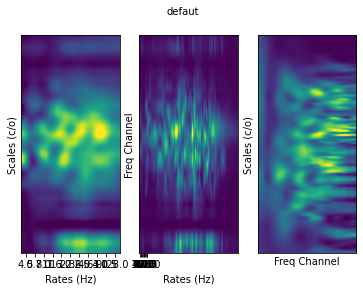

In [179]:
plotStrfavg(strf_scale_rate, strf_freq_rate, strf_freq_scale, aspect_='auto', interpolation_='sinc',figname='defaut',show='true')

array([-128. ,  -90.5,  -64. ,  -45.3,  -32. ,  -22.6,  -16. ,  -11.3,
         -8. ,   -5.7,   -4. ,    4. ,    5.7,    8. ,   11.3,   16. ,
         22.6,   32. ,   45.3,   64. ,   90.5,  128. ])